I am copying this from Annie's tutorial on InfleCS.

The main idea with this is firstly to just play around with the data a bit and understand if I can get something meaningful out of this

If you want, you can only run the first two lines and then skip to the bottom to do only analysis on the **path** that the strings take and the **cluster_centers** that are generated from InfleCS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import free_energy_clustering as FEC

In [2]:
condition = 'influx_apo_gate_CV'
indir = f'../../../../string_sims/TMD_initial_path/{condition}/postprocessing'
strings = np.load(f'{indir}/cv_coordinates.iterations.100_745.npy')
#strings = np.load(f'{indir}/cv_coordinates.iterations.100_552.npy')


## reshape to flatten out (start_swarm, end_swarm), and then swap the order of the strings so that it's
## IC, EC to be X,Y
data = strings.reshape(np.shape(strings)[0]*2, 2)
data = data[:,[1,0]]



max_n_components = 10

Run this to start GMM FES again

In [3]:
fec = FEC.FreeEnergyClustering(data, min_n_components=2, max_n_components=max_n_components, temperature=303.15, 
                            n_iterations=5, n_grids=80, n_splits=1,stack_landscapes=False)

coords, FE_landscape, FE_points = fec.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 5
   n_grids = 80
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.948405, 1.54299], [0.746192, 1.5943]]
   temperature = 303.15
   min_n_components = 2
   max_n_components = 10
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 2
# Components = 3
# Components = 4
# Components = 5
# Components = 6
# Components = 7
# Components = 8
# Components = 9
# Components = 10
Identifying final model with 10 components.
Evaluating density in landscape
Density grid shape: [80, 80]


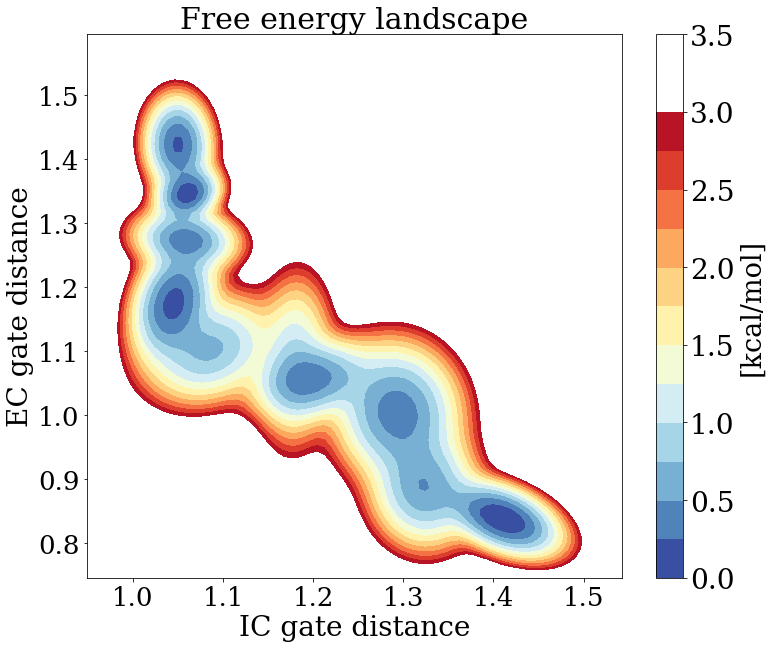

In [4]:
vmax = 3
fec.visualize(savefig=True, show_data=False, vmax=vmax, xlabel='IC gate distance', ylabel='EC gate distance',\
              filename=f'../../../images_figs/infleCS/{condition}.free_energy_landscape.cutoff{vmax}.max_components{max_n_components}',title='Free energy landscape')

In [5]:
labels, cluster_centers = fec.cluster(coords, FE_points, data, assign_transition_points=False)
print("Cluster center indices: "+str(cluster_centers))

# Computing state populations
state_populations = fec.population_states(n_sampled_points=100000)

Clustering free energy landscape...
Computing Hessians of density landscape.
Point: 6400/6400
Constructing connected components.
# Graph connections: 2942.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Done clustering.
Cluster center indices: [482035 278503 458487 195801 569283 392667 416739 413149 534121]
Sampling points from density.
Assigning cluster labels based on precomputed density model clustering.
Computing state populations.


/data2/GLUT5_string/string/analysis/scripts/infleCS/InfleCS-free-energy-clustering-tutorial-master/free_energy_clustering/GMM_free_energy.py:628: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.scatter(self.data_[self.cluster_centers_,0], self.data_[self.cluster_centers_,1], marker='s', s=120,


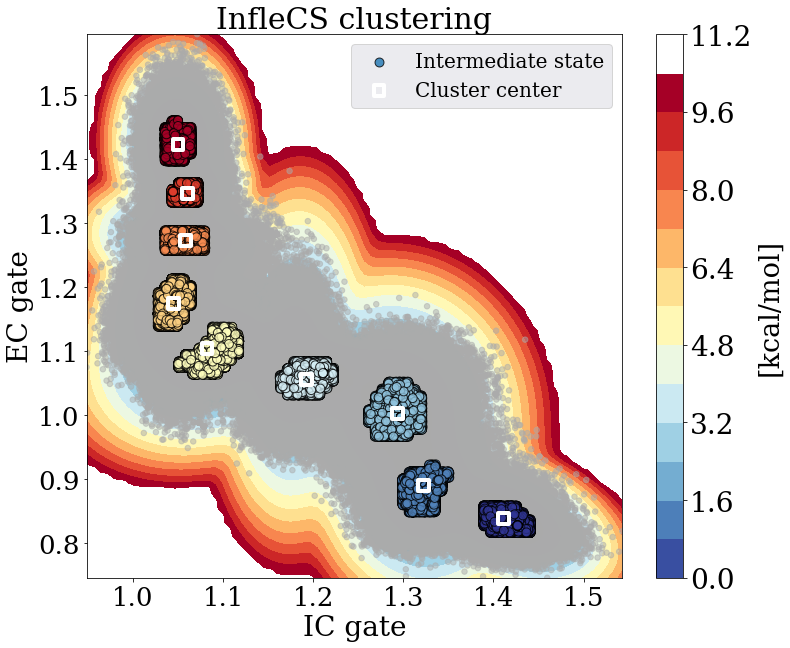

In [6]:
# Visualize free energy landscape with cluster labels
fec.pathways_ = None
fec.visualize(savefig=False, show_data=True, vmax=10, xlabel='IC gate', ylabel='EC gate', filename='InfleCS_clustering', title='InfleCS clustering')

plt.savefig(f'../../../images_figs/infleCS/{condition}.infleCS_clustering.png', dpi = 800)

([<matplotlib.axis.XTick at 0x7f423e23ca30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

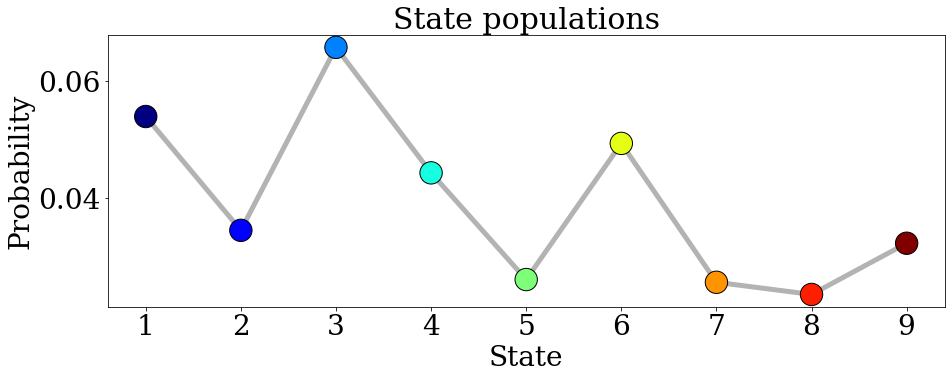

In [7]:
# Plotting the state populations
plt.figure(figsize=[15,5]);
plt.plot(np.arange(1,state_populations.shape[0]),state_populations[1::]/state_populations.sum(),linewidth=5,color=[0.7,0.7,0.7],zorder=-1)
plt.scatter(np.arange(1,state_populations.shape[0]),state_populations[1::]/state_populations.sum(),s=500,c=np.arange(1,state_populations.shape[0]),cmap='jet',edgecolor='k')
plt.title('State populations',fontsize=30)
plt.xlabel('State',fontsize=28)
plt.ylabel('Probability',fontsize=28)
plt.xticks(np.arange(1,state_populations.shape[0]))

#plt.savefig(f'../../../images_figs/infleCS/{condition}.state_populations.png', dpi = 800)

Iteration: 2000/2000


/data2/GLUT5_string/string/analysis/scripts/infleCS/InfleCS-free-energy-clustering-tutorial-master/free_energy_clustering/GMM_free_energy.py:628: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.scatter(self.data_[self.cluster_centers_,0], self.data_[self.cluster_centers_,1], marker='s', s=120,


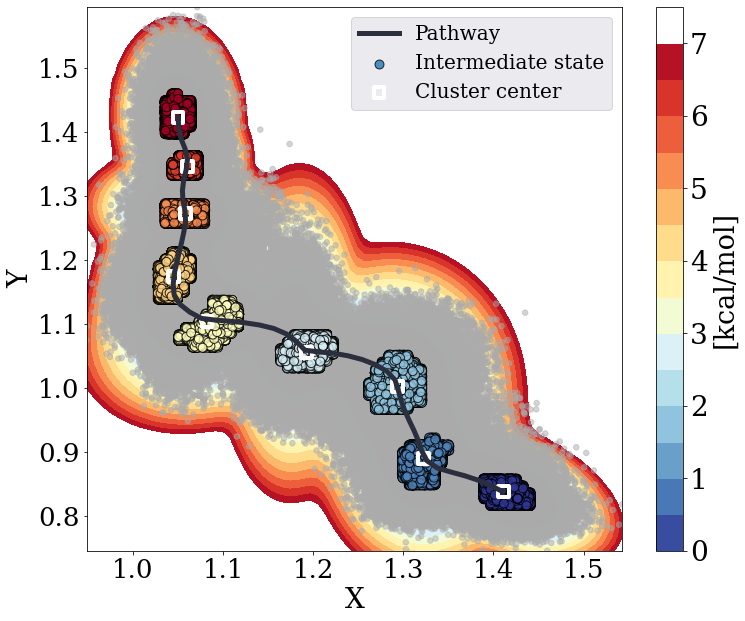

In [8]:
path = fec.pathways([cluster_centers[0]], [cluster_centers[8]],max_iter=2000,\
             convergence_tol=1e-4,step_size=1e-5,n_points=50)

fec.visualize(savefig=False, vmax=7, show_data=True, xlabel='X', ylabel='Y', filename='pathways', title='')

In [16]:
np.save(f'./paths_clustercenters/pathway_{condition}.{max_n_components}_clusters.2000_iterations.npy', path)
np.save(f'./paths_clustercenters/clustercenters.{condition}.{max_n_components}_clusters.npy', cluster_centers)

# Analysis of InfleCS results & parsing for looking at confout files

If you have already run the things above and haven't changed anything, you can just load the `path` and `cluster_centers`

- `path` will have the shape (IC, EC)

You also want to define the # swarms, iterations, and beads for the string sims because you will have to cut out these indices to find out what `confout` files are belonging to the cluster centers and path

In [11]:
from scipy import spatial
plt.rcParams.update(plt.rcParamsDefault)

path = np.load(f'./paths_clustercenters/pathway_{condition}.{max_n_components}_clusters.2000_iterations.npy')[0]
cluster_centers = np.load(f'./paths_clustercenters/clustercenters.{condition}.{max_n_components}_clusters.npy')

n_swarms = 32
n_beads = 14

Remember: strings are shaped as:`(n_iterations*n_beads*n_swarms_per_iter, n_frames_per_iter, n_cvs)`

**but** we have flattened out the `n_frames_per_iter` so the index of `strings` will be roughly half of `data`

- First flip back to EC,IC so we will be able to find indices in `strings`
- Then transform `cluster_centers` to the indexes of `strings` rather than of `data`, and check that they match
- Extract iteration, bead, swarm that the clusters
    - You'll notice the indices go in order based on bead #'s, which is correct

In [4]:
data_flip = data[:,[1,0]]

In [27]:
def get_it_bead_swarm_from_index(index_number, iteration_start):
    #### divide index by 448 to find which iteration it's in
    iteration = int(np.floor(index_number / (n_swarms * n_beads))) 
    

    #### find which index this dictated iteration starts on
    iteration_start_string_index = (n_swarms * n_beads) * iteration  


    #### take the difference of the iteration start index and the actual index
    #### The difference between the actual index and iteration index / 32 will be which bead 
    bead = int(np.floor((index_number - iteration_start_string_index) / n_swarms)) 


    #### find which index this bead starts on
    #### will be iteration start + (1-448)
    bead_start_string_index = iteration_start_string_index + (n_swarms * bead)


    #### Get actual index - bead index start, max diff should be 31
    swarm = index_number - bead_start_string_index
    
    actual_iteration = iteration + iteration_start
    print(f"Returning iteration {actual_iteration}, bead {bead}, swarm {swarm}")
    
    
    #indir = f'../../../../string_sims/TMD_initial_path/{condition}/md'    
    indir = f'/mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/{condition}/md'
    confout_statement = f"{indir}/{actual_iteration}/{bead + 1}/s{swarm}/traj_comp.xtc"
    print(f"Confout should be in: {confout_statement}")
    return actual_iteration, bead, swarm, confout_statement
    

In [28]:
string_cluster_centers = []

for center in cluster_centers:
    data_loc = data_flip[center]
    
    ## if the center is an odd number, this means it's in strings in the second index (since strings is x, 2, 2)
    if center % 2 == 1:
        string_center = int(np.floor(center / 2) )
        string_loc = strings[string_center][1] 
    else:
        string_center = int(center / 2)
        string_loc = strings[string_center][0]
    
    string_cluster_centers.append(string_center)
    
    if (string_loc != data_loc).all():
        print(f"Not a match at position {center}, string index will be wrong")
    else:
        print(f"Matching data and string at index (d{center}, s{string_center}) with vals (d{data_loc}, s{string_loc})")
        
        
    iteration, bead, swarm, confout = get_it_bead_swarm_from_index(string_center, 100)
    print()
    print()

Matching data and string at index (d482035, s241017) with vals (d[0.838047 1.41071 ], s[0.838047 1.41071 ])
Returning iteration 637, bead 13, swarm 25
Confout should be in: /mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV/md/637/14/s25/traj_comp.xtc


Matching data and string at index (d278503, s139251) with vals (d[0.890211 1.32276 ], s[0.890211 1.32276 ])
Returning iteration 410, bead 11, swarm 19
Confout should be in: /mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV/md/410/12/s19/traj_comp.xtc


Matching data and string at index (d458487, s229243) with vals (d[1.00305 1.29379], s[1.00305 1.29379])
Returning iteration 611, bead 9, swarm 27
Confout should be in: /mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV/md/611/10/s27/traj_comp.xtc


Matching data and string

### Finding these points on the path

`path` is shaped as (IC,EC). We will find the indices where `path` is closest to `data` and then perform the same functions as above
- Write out the xtc files detected to `trjcat_inflecs.sh`
- Run `trjcat_inflecs` separately
- Check that this works well by calculating gate dists on trajectory

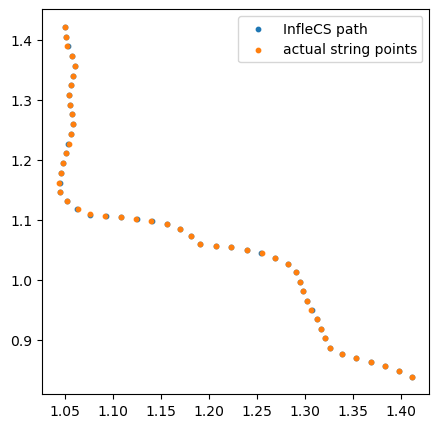

In [109]:
distance,path_indices = spatial.KDTree(data).query(path)

f = plt.figure(figsize = (5,5))

plt.scatter(path[:,0], path[:,1], s = 10, label = 'InfleCS path')
plt.scatter(data[path_indices][:,0], data[path_indices][:,1], s = 10, label = 'actual string points')
plt.legend()
plt.show()

In [93]:
string_path_centers = []

confout_list = []

for path_index in path_indices:
    data_loc = data_flip[path_index]
    
    ## if the center is an odd number, this means it's in strings in the second index (since strings is x, 2, 2)
    if path_index % 2 == 1:
        string_center = int(np.floor(path_index / 2) )
        string_loc = strings[string_center][1] 
    else:
        string_center = int(path_index / 2)
        string_loc = strings[string_center][0]
    
    string_path_centers.append(string_center)
    
    if (string_loc != data_loc).all():
        print(f"Not a match at position {path_index}, string index will be wrong")
    else:
        print(f"Matching data and string at index (d{path_index}, s{string_center}) with vals (d{data_loc}, s{string_loc})")
        
        
    iteration, bead, swarm, confout = get_it_bead_swarm_from_index(string_center, 100)
    confout_list.append(confout)
    print()
    print()

Matching data and string at index (d482035, s241017) with vals (d[0.838047 1.41071 ], s[0.838047 1.41071 ])
Returning iteration 637, bead 13, swarm 25
Confout should be in: /mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV/md/637/14/s25/traj_comp.xtc


Matching data and string at index (d358285, s179142) with vals (d[0.848094 1.39719 ], s[0.848094 1.39719 ])
Returning iteration 499, bead 12, swarm 6
Confout should be in: /mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV/md/499/13/s6/traj_comp.xtc


Matching data and string at index (d281221, s140610) with vals (d[0.85611 1.38331], s[0.85611 1.38331])
Returning iteration 413, bead 12, swarm 2
Confout should be in: /mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV/md/413/13/s2/traj_comp.xtc


Matching data and string at

Write out the code to make the trajectory from the path and calculate pairwise distances

**This was very different from using gate_distance which uses MDAnalysis, so watch out for that in the future!!!**

In [102]:
trjcat_inflecs = open('trjcat_inflecs.sh', 'w')

trjcat_inflecs.write('gmx trjcat -f ')

for n in confout_list:
    trjcat_inflecs.write(n + ' ')

trjcat_inflecs.write(f'-o paths_clustercenters/{condition}.inflecs_path.xtc -cat -b 10')  #only write last frame, as this is result from swarm that we desire

trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx pairdist -f paths_clustercenters/{condition}.inflecs_path.xtc '
                     f'-s ../../../confout_files/tpr_files/{condition}.wholesys.tpr '
                    '-ref "com of resid 30 to 37" -sel "com of resid 289 to 295" '
                    f'-o paths_clustercenters/{condition}.inflecs.EC_gate.xvg -xvg none'
                    )
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx pairdist -f paths_clustercenters/{condition}.inflecs_path.xtc '
                     f'-s ../../../confout_files/tpr_files/{condition}.wholesys.tpr '
                    '-ref "com of resid 136 to 145" -sel "com of resid 386 to 394" '
                    f'-o paths_clustercenters/{condition}.inflecs.IC_gate.xvg -xvg none'
                    )

trjcat_inflecs.close()

Finally, plot `path` vs the `gmx pairdist` output from the written trajectory to compare what my trajectory looks like

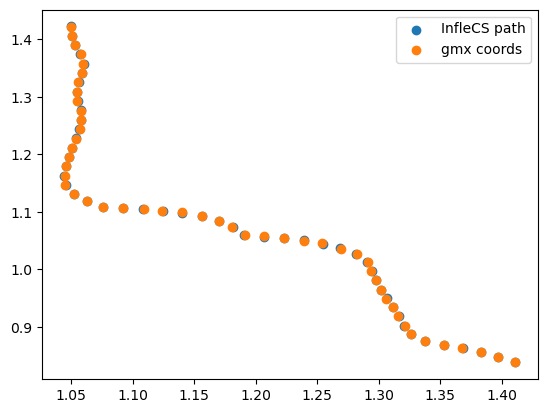

In [108]:
ic_gmx = np.loadtxt('paths_clustercenters/influx_apo_gate_CV.inflecs.IC_gate.xvg')[:,1]
ec_gmx = np.loadtxt('paths_clustercenters/influx_apo_gate_CV.inflecs.EC_gate.xvg')[:,1]

plt.scatter(path[:,0], path[:,1], label = 'InfleCS path')
plt.scatter(ic_gmx, ec_gmx, label = 'gmx coords')
plt.legend()
plt.show()